# Lab 4 Noise and Decision Making

> Yujia, Ethan, and Vincent adapted from materials developed by Diane and Elizabeth
> 
> 2024/4/11 (Week 4)

Edit this document directly. As you go through the notebooks you will find numbered questions. Please answer in the cells provided. 
   
This is an individual assignment, but you are allowed (encouraged!) to work together in groups and discuss coding and
answers. That said, you are responsible for all the material in this laboratory assignment. **DO NOT
COPY from anyone that you work with.** You are **NOT** allowed to share code. You need to write the code
and answer the questions yourself. Try the coding yourself first before seeking help.

<div class="alert alert-info" role="alert">
    
__Total Points 15__

__Due: 4/18 Thursday 1:30 pm__ -- by the start of your first lab session in week 5.
</div>

If you have any questions, please do not hesitate to ask. You can find the emails and office hours of your instructors and TAs on Canvas. Best of luck!

Feel free to go to the Quantitative Biosciences Center for help! 
[https://college.uchicago.edu/academics/quantitative-biosciences-center](https://college.uchicago.edu/academics/quantitative-biosciences-center) 



### Noise?

In the first three weeks you've played around with a few network motifs and explored their dynamics
either by some pencil and paper, by graphical intuition, or by numerical simulations.
You also hope to understand more complicated biological systems by treating the simple motifs as
"lego bricks" and studying their inputs and outputs.

However, the simulations up until now are _deterministic_ but biology can be _noisy_.
What do I mean by noise?
There can be different sources of noise, e.g. cells can feel fluctuactions from their environment.
Even if the environment is perfectly stable and homogeneous, molecules are jiggling and wiggling all the time.
The cells can feel _intrisic noise_ through thermal fluctuations and the potentially low copy number of molecules.

Today you will demonstrate what noise can do by computer simulations.
__You will see that noise may not just be a nuisance but something that biology finds useful.__

## Stochastic Differential Equations

Stochastic differential equations, or SDEs, are (loosely speaking) ordinary differential equations that include __random variable(s)__.
E.g. we can introduce noise into a simple gene expression model

<img alt="Simple gene expression" src="https://github.com/dschnitkey/BIOS20236/blob/main/simplyregulated.png?raw=true" width="300px" />

$$
\frac{dX}{dt} = \beta - \alpha X + A\xi(t)
$$

Here $\xi(t)$ is a random process. You can think of it as __Brownian motion__.
When your computer integrates such an equation, it will draw different numbers from white noise in place of $\xi(t)$.
These random numbers have a mean of 0 and variance of 1.

A is the **noise strength** that determines how big these fluctuations are. When A = 0, you get back to the original deterministic model.

### SDE in Python

First, you want to install the `sdeint` package. Unfortunately it is not included in the Anaconda distribution so you'll have to install it manually through `pip`.

In your terminal (where to find it is OS dependent. Google or ChatGPT should give your some clue) run command

`pip install sdeint`

and you are good to go! The Prelab video also walks you through the installation.

Run the following cell. It wraps up SDE solver and exposes an interface that resembles `odeint`. __You should treat it as a black box when you use it__ - you don't have to change anything about this function

In [180]:
from sdeint import itoint
import numpy as np

def sdeint_wrapper(rhs, u0, tspan, A, args):
    # ensure the derivatives are an np array
    sol = itoint(lambda x, t: np.array(rhs(x, t, *args)),
                 # only allow independent noise (as a diagonal vector)
                 # if the state variable is 1D, use a scalar A
                 lambda x, t: A if not hasattr(x, "__len__") else np.diag(A*x**0),
                 u0, tspan)
    return sol

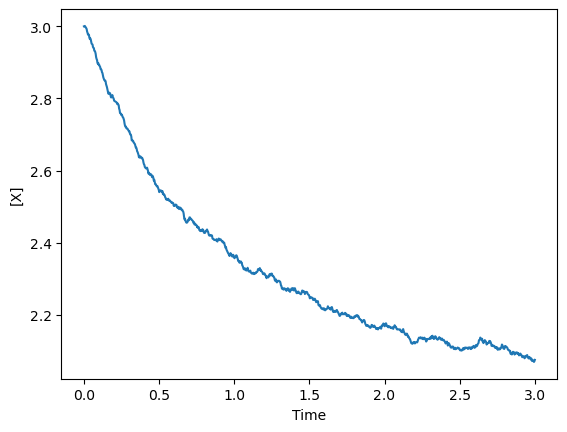

In [181]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import odeint

def rhs_simple(x, t, beta, alpha):
    return beta - alpha*x

beta = 2
alpha = 1
A = 0.05

tspan = np.linspace(0, 3, 1001)
x0 = 3

args = (beta, alpha)
sol = sdeint_wrapper(rhs_simple, x0, tspan, A, args)

p, ax = plt.subplots()
ax.plot(tspan, sol, label="Noisy")
ax.set_xlabel("Time")
ax.set_ylabel("[X]")
plt.show()

Overlaying a deterministic curve. Feel free to play around with the __noise strength, $A$__

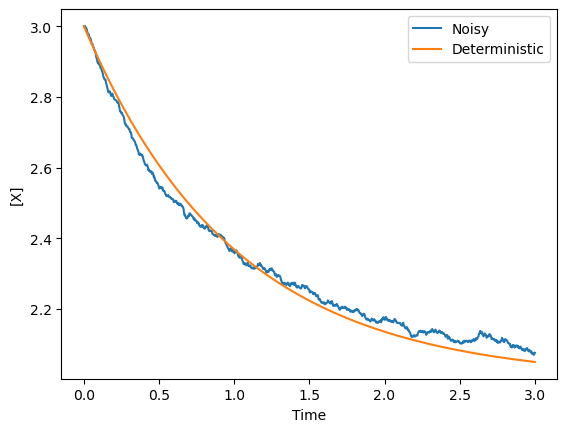

In [182]:
sol2 = odeint(rhs_simple, x0, tspan, args)

ax.plot(tspan, sol2, label="Deterministic")
ax.legend()
p

As you start to explore the behavior of different noisy systems with SDE, you may encounter _negative concentrations_.
This, of course, is not biologically meaningful.
Suppose your noisy system reaches a stable steady state of 0.
After it settles at the steady state, the system will _randomly walk_ around 0 and reach some negative numbers transiently.

__In this notebook we are not going to worry about the negative numbers if they only show up transiently__
(however if your trace centers around some negative numbers you should double-check your work!).
There are exact simulation methods, e.g. the Gillespie algorithm, that avoids negative concentrations but are more computationally expensive.

<h3 style="color:blue;">Tasks for Part 1</h3>

__1.1__ Simple gene expression model and positively and negatively autoregulated gene with noise.

Solve the three model starting from $X = 5$. Use time span from 0 to 10 (you will decide the time step size).
As a quick reminder, the equations for the three models are

__Simply regulated gene__

$$
\frac{dX}{dt} = \beta - \alpha X
$$

__Positively autoregulated gene__

$$
\frac{dX}{dt} = \beta_0 + \beta\frac{X^n}{X^n + K^n} - \alpha X
$$

__Negatively autoregulated gene__

$$
\frac{dX}{dt} = \beta_0 + \beta\frac{K^n}{X^n + K^n} - \alpha X
$$

Please use noise strength $A = 0.1$. Other parameters are provided for you. Add titles and axis labels as you see appropriate

In [1]:
beta = 2    # use this param for all three models!
beta0 = 0.2
n = 6
K = 2
alpha = 1

A = 0.1

# your answer 1.1


__1.2__ Repeat Task 1.1 with a different noise strength of your choice. E.g. You can try $A = 0.5$ to see what stronger noise can do to different systems. The noise strength should be a non-negative real number.

Please print out/label on the plot your choice of $A$.

In [2]:
# your answer 1.2



__1.3 A noisy coherent feedforward loop (FFL).__

In Lab 3 you have shown that a coherent FFL with an AND gate can act as a __persistence detector__.
You showed it by transiently turning on $X$ but the second output, $Z$, had little activation.

In reality, a gene may be turned on stochastically, e.g. by a fluctuating input signal or by "bursty" gene expression (as shown in this [famous paper by Cai et al.](https://www.nature.com/articles/nature04599)).
Here we assume that the noise only comes from $X$.
You can justify it by imagining that $X$ senses some fluctuating extrinsic signal or that $X$ exists in low copy number which makes it exceptionally bursty.
And we will model $Y$ and $Z$ as deterministic.

Here's how we will do it. We are going to make $A$ a 3-element vector to represent the noise strength of $X$, $Y$, and $Z$ respectively.
Please use the new `sdeint_wrapper` function in this notebook! The one in the Prelab notebook can only handle 1D cases.

Then, you want to define a right-hand side function for your FFL with an AND gate. You've done this part in Lab 3 task 2.8. Feel free to copy and pase your code here. All the parameters are provided for you (different from Lab 3!). Simulate a noisy model with SDE and use $A$ in the cell below. Notice that there is no noise for $Y$ and $Z$. There's no need to turn off $S$ because the dynamics of $X$ will be driven by noise. If you keep the `if` statement from Lab 3, it's okay because `t_thresh` is set to a very big number and you'll never reach it.

Plot Your $X$, $Y$, and $Z$ in separate graphs. Limit the y-axis from 0 to 5 for all your graphs. Overlay a dotted horizontal line representing $K_X$ in the $X$ graph and a dotted horizontal line representing $K_Y$ in the $Y$ graph. Simulate from $t = 0$ to 100. All three proteins start from 0.

If successful, you should see that though $X$ and $Y$ fluctuate, $Z$ is barely turned on - __If needed, biology can use such a mechanism to filter out much of the fluctuations__

In [3]:
# Parameters

S = 1
a_x = 0.4
a_y = .2
a_z = .2
b_y = 3
b_z = 1
K_x = 4
K_y = 4
n = 20
t_thresh = 1e5

A = [0.8, 0, 0]

# Your answer 1.3



## Unstable Steady State

In Lab 2 you are familiar with the idea that a positive autoregulated motif can have two stable steady states.
In general, you may often find _multistability_ in a positive feedback loop.
The idea is that a positive feedback loop reinforces the current state
which helps the cell to _commit to_ the decision that it has made.

In this section we will dig more into the _unstable steady states_.
They are the intermediate states where cells are _poised_ to make a decision.
We will see how noise plays a crucial role in the dynamics near an unstable steady state.

<h3 style="color:blue;">Tasks for Part 2</h3>

__2.1 Check an unstable steady state.__ The right hand-side function evaluates to 0 at a steady state. For a positively autoregulated motif

$$
\frac{dX}{dt} = \beta_0 + \beta\frac{X^n}{X^n + K^n} - \alpha X
$$

With parameters

$$
\begin{align}
\beta_0 &= 0.2\\
\beta &= 3.6\\
K &= 2\\
n &= 6\\
\alpha &= 1
\end{align}
$$

<!-- beta = 4alpha - 2beta0 -->

It has an unstable steady state at $X_{ss} = 2$.
To show that 2 is indeed an unstable steady state, first define a RHS function for the positively autoregulated motif (you may have done that in Part 1). Then print out the function return value when $X = 2$.

In [4]:
# your answer 2.1



__2.2__ As a second step to check the unstable steady state, make a flux balance plot and overlay a vertical dashed line at $X = 2$.
Use different colors to show the production and the degradation fluxes.

Does the vertical line cross the intersection of the production and degradation curves? 
If you draw arrows on the x-axis to represent the derivatives, where will the arrows immediately left or right of $X = 2$ point to?

In [5]:
# your answer 2.2



__Edit this cell to include your answer__



__2.3__ Plot the deterministic solution of the positive autoregulation model with starting conditions
$X(t = 0) = 1.9, 2.0, \text{ or } 2.1$. Overlay the three curves on the same plot.
Make sure that you integrate for a long enough time for the traces to reach their steady states.
Label each curve with its starting condition.

Before you plot, imagine what the solutions will be like based on your flux balance plot. Then see if the numerical solution agrees with your expectation.

In [6]:
# your solution 2.3



__2.4__ Here comes the noise. Simulate the same model with SDE and set the noise stregth to 0.5.

First, overlay 20 solutions of the SDE starting from $X(0) = 1.9$. Do all traces converge to the same steady state as the deterministic one?

Second, overlay 20 solutions of the SDE starting from $X(0) = 2.0$ on a different graph (please show your starting condition in the plot title). Do all traces converge to the same steady state as the deterministic one?

In [7]:
# your solution 2.4



__Edit this cell to include your answer__



Hopefully through this example you were convinced that, due to noise, a biological system does not settle at an unstable steady state.

However, it can be still insightful to find the unstable steady states because they are __right on the boundary of two (or more) basins of attraction to stable steady states.__
The unstable steady states set apart the cells/molecules/populations that commit to different decisions.

## Stochastic Switching

__3.1 Escape a stable steady state!__ Simulate 100 traces of the positively autoregulated gene starting from $X(0) = 0$. Use noise strength = 0.2. Repeat with noise strength = 0.4 (please plot on two figures). Use the parameters given in the cell ($A$ is for you to assign). Simulate from $t = 0 \text{ to } 100$.

<div class="alert alert-warning" role="alert">   
    
This task is more computationally demanding than your previous ones (can take > 10 seconds to run). Choose your time step size wisely
            
</div>   

Do you see any traces escaping the stable steady state close to 0? How does increased noise affect the number of escapers? (You don't have to write down the answers)

In [8]:
beta0 = 0.6
beta = 3.6
K = 2
n = 4
alpha = 1

# your solution 3.1



__3.2__ Make a flux balance plot using the parameters in task 3.1

In [9]:
# your answer 3.2



__3.3 Stochastic switching.__ With an appropriate level of noise and shallow basins of attraction (qualitatively speaking - from the class we don't have the tools to ask quantitatively how deep a basin of attraction is) for both stable steady states,
a system may stochastically switch between stable steady states.

It can be very helpful to biology. With a stochastic switch, an organism or population can sample different decisions without committing to any of it.
Such _reversible_ decision making may help organisms to survive rapidly changing environment.

Here you will demonstrate that a positively autoregulated motif with noise can achieve stochastic switching.
Start with the same model as Task 3.1 and 
use $A = 0.4$. __You will change up to two parameters to make it a stochastic switch.__
Please print out which parameters you've changed and to what value. 
Simulate 3 traces starting from 0 and show that your system can reversibly jump between 2 states. Here is an example

__Hint:__ Use a flux balance plot to guide your choice. Try to go back and forth between 3.3 and 3.4 and think about how the distance between the stable and unstable steady states can affect the chance to make a jump.
__You should consider the unstable steady state as a "tipping point" before jumping__

![Simulations of a stochastic switch](https://github.com/yuja-liu/bios20236_2024/blob/main/lab4/figs/stochastic_switching_simulations.png?raw=true)

In [ ]:
# your solution 3.3

__3.4__ Make a flux balance plot of the stochastically switching positively autoregulated motif.

How does the position of the steady states (including stable and unstable ones) and the shape of the curve change compared to Task 3.2?

In [10]:
# your solution 3.4



__Edit this cell to include your answer__

